In [91]:
import torch 
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [92]:
# new_words=pd.read_csv("data/amharic_names.csv")
# old_words=open("data/cleaned_words.txt","r").read().splitlines()
# new_amh_words=new_words["in_am"].tolist()
# am_words=new_amh_words + old_words
am_words=open("data/english_names.txt","r").read().splitlines()

In [93]:
chrs=sorted(set(list("".join(am_words))))
stoi={s:i+1 for i,s in enumerate(chrs)}
stoi["."]=0
itos={i:s for s,i in stoi.items()}

In [94]:
block_size=3
def build_dataset(am_words):
    X,Y=[],[]
    for w in am_words:
        context=[0]*block_size
        for ch in w +".":
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
            # print("".join(itos[i] for i in context),'---->',itos[ix])
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X,Y

In [95]:
random.seed(42)
random.shuffle(am_words)
n1=int(0.8*(len(am_words)))
n2=int(0.9*(len(am_words)))

Xtr,Ytr=build_dataset(am_words[:n1])      #80
Xval,Yval=build_dataset(am_words[n1:n2])  #10
Xte,Yte=build_dataset(am_words[n2:])      #10

In [96]:
# kaiming init
'''
the gain of tanh is 5/3
fan_in = n_embed*blocksize

5/3 / (30**0.5)
'''

'\nthe gain of tanh is 5/3\nfan_in = n_embed*blocksize\n\n5/3 / (30**0.5)\n'

In [97]:
n_embed=10  # dimensionality of the char embedding vector
n_hidden=200
vocab_size=len(itos)

g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embed), generator=g)
W1=torch.randn((n_embed*block_size,n_hidden), generator=g) * (5/3)/((n_embed*block_size)**0.5) # kaiming init
b1=torch.randn(n_hidden, generator=g)                      *0.01
W2=torch.randn((n_hidden,vocab_size), generator=g)         *0.01
b2=torch.randn(vocab_size, generator=g)                    *0

bngain=torch.ones((1,n_hidden))
bnbais=torch.zeros((1,n_hidden))

bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))

parameters=[C,W1,b1,W2,b2,bngain,bnbais]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True

12297


- if the first loss is very high the initialization is messed up
- each char has 188 pr of 1/188


this is what we expect on the first loss
```
(-torch.tensor(1/188.0).log())

---> 5.2364

```

if it is high we have to normaize the logits

```
logits=h@W2+b2
```


In [98]:
max_step=200000

batch_size=32
lossi=[]

for i in range(max_step):

    #minibatch
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]

    #forward pass
    embed=C[Xb]   #embed the char into vectors
    embed_cat=embed.view(embed.shape[0],-1) 
    hid_preact=embed_cat@W1+b1    #hidden layer

    #batch norm
    bnmeani=hid_preact.mean(0,keepdim=True)
    bnstdi=hid_preact.std(0,keepdim=True)
    hid_preact=bngain*(hid_preact- bnmeani )/ bnstdi + bnbais

    '''
    During training, the batch statistics are used for normalization. 
    However, during inference (testing or deployment), the running estimates 
    are used to normalize the data. This ensures that the model behaves consistently
      and efficiently when making predictions on new, unseen data.
    '''
    with torch.no_grad():
        bnmean_running=0.999*bnmean_running +0.001*bnmeani
        bnstd_running=0.999*bnstd_running +0.001*bnstdi


    h=torch.tanh(hid_preact)  #hidden layer
    logits=h@W2+b2 #output layer
    loss=F.cross_entropy(logits,Yb)

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    #update
    lr=0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    
    #track stats
    if i%1000==0:
        print(f"{i:7d}/{max_step:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.3147
   1000/ 200000: 2.1945
   2000/ 200000: 2.3061
   3000/ 200000: 2.2337
   4000/ 200000: 2.1661
   5000/ 200000: 2.3550
   6000/ 200000: 2.1222
   7000/ 200000: 2.4549
   8000/ 200000: 2.0116
   9000/ 200000: 2.2276
  10000/ 200000: 2.1984
  11000/ 200000: 1.8837
  12000/ 200000: 2.2050
  13000/ 200000: 2.2054
  14000/ 200000: 2.6501
  15000/ 200000: 2.0817
  16000/ 200000: 2.4526
  17000/ 200000: 2.2701
  18000/ 200000: 2.0249
  19000/ 200000: 2.3733
  20000/ 200000: 2.3375
  21000/ 200000: 2.4851
  22000/ 200000: 1.9193
  23000/ 200000: 1.9813
  24000/ 200000: 2.5391
  25000/ 200000: 2.3289
  26000/ 200000: 2.3917
  27000/ 200000: 2.4123
  28000/ 200000: 2.0773
  29000/ 200000: 2.6299
  30000/ 200000: 2.4359
  31000/ 200000: 2.2457
  32000/ 200000: 2.4601
  33000/ 200000: 2.3236
  34000/ 200000: 1.9366
  35000/ 200000: 2.3067
  36000/ 200000: 2.1359
  37000/ 200000: 2.0240
  38000/ 200000: 2.6379
  39000/ 200000: 2.1167
  40000/ 200000: 2.0119
  41000/ 200000:

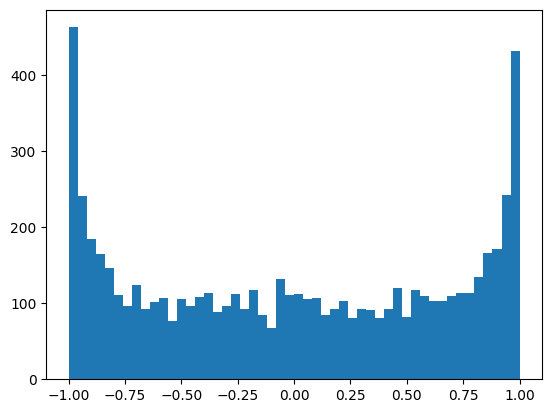

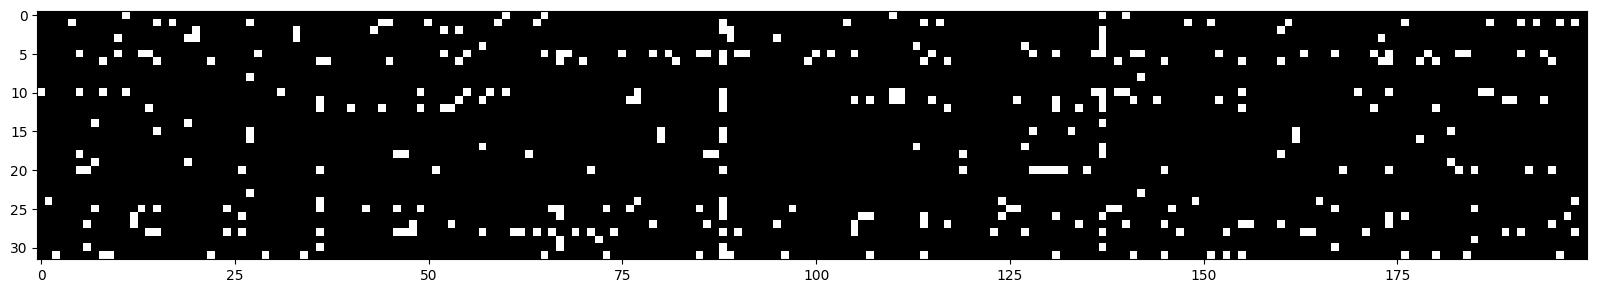

In [99]:
'''
- Here for tanh linear activation functions the range is between -1 and 1
- In the saturation regions of tanh, the derivative (gradient) is very small.
During backpropagation, these small gradients can cause the updates to the weights 
to be very small, slowing down the training process or even causing it to stall.
'''
plt.hist(h.view(-1).tolist(),50)

# plt.hist(hid_preact.view(-1).tolist(),50)

# - if the entire column is white it is dead neuron

plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99 ,cmap="gray", interpolation="nearest")


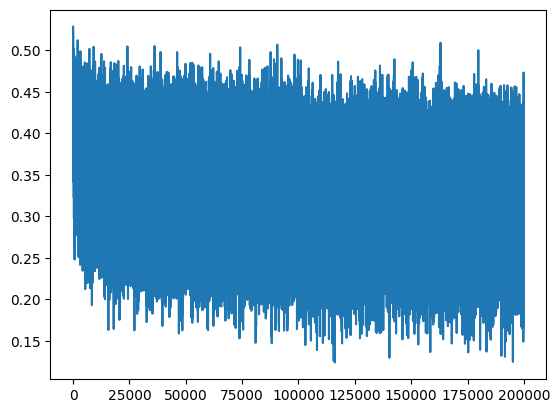

In [103]:
plt.plot(lossi)

In [104]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]    
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hid_preact=embcat @ W1 + b1
    hid_preact=bngain*(hid_preact- hid_preact.mean(0,keepdim=True))/hid_preact.std(0,keepdim=True) + bnbais
    h = torch.tanh(hid_preact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491
